In [1]:
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, r2_score
import sqlite3
from datetime import datetime
import matplotlib.dates as mdates


In [2]:
def requete_sql (requete) :
    try:
        connexion = sqlite3.connect('./data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)

# Import des données
## Sélection des piezos

Récupération des codes_bss par jointure de tables dans la base de données

In [3]:
region = "NOR"

requete = f"""
        SELECT code_bss
        FROM data_piezo
        INNER JOIN code_region
            ON code_dpt = departement
        WHERE code_region IS '{region}'
        AND fichier_piezo IS 1
         """
data = requete_sql(requete)
code_bss = []
for code in data:
    code_bss.append(code[0]) 

Connexion réussie à SQLite
Connexion SQLite est fermée


In [4]:
code_bss

['02516X0071_P3-90',
 '01446X0005_S3-91',
 '01506X0016_P1',
 '01474X0048_P1',
 '01801X0010_S1',
 '00572X0010_S1',
 '01245X0010_S1',
 '02151X0030_S1',
 '00753X0030_S1',
 '00985X0040_S1',
 '00592X0001_S1',
 '01487X0001_S1',
 '01252X0011_S1',
 '01795X0011_S1',
 '01184X0021_S1',
 '01807X0051_S1',
 '01232X0002_S1',
 '00773X0002_S1',
 '00993X0002_S1',
 '01256X0002_S1',
 '00578X0002_S1',
 '01198X0002_S1',
 '01461X0012_S1',
 '01492X0012_S1',
 '02535X0012_S1',
 '01462X0072_S1',
 '01002X0003_S1',
 '00603X0003_S1',
 '01004X0003_S1',
 '01463X0103_S1',
 '00955X0023_S1',
 '01508X0133_S1',
 '01192X0043_S1',
 '00578X0043_S1',
 '00751X0004_S1',
 '01191X0004_S1',
 '00762X0004_S1',
 '01013X0004_S1',
 '00766X0004_S1',
 '00604X0224_S1',
 '01251X0044_S1',
 '01193X0044_S1',
 '01017X0074_S1',
 '00583X0005_S1',
 '02144X0005_S1',
 '00957X0005_S1',
 '01515X2015_S1',
 '01794X0035_S1',
 '00956X0055_S1',
 '00755X0006_S1',
 '00608X0206_S1',
 '01805X0036_S1',
 '01213X0166_S1',
 '01216X0086_S1',
 '00776X0096_S1',
 '00

## Construction d'un dataframe

In [5]:
directory = './data/piezo/'

# Lecture des données du premier piezo de la liste pour initialiser le dataframe
data = pd.read_csv(directory+f"{code_bss[0]}.csv", sep=";",  index_col=0, parse_dates=True)
data.rename(columns={"piezo":f"{code_bss[0]}"}, inplace=True)

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")

for file in code_bss[1:]:
    df = pd.read_csv(f"{directory+file}.csv", sep=";",  index_col=0, parse_dates=True, date_parser=custom_date_parser)
    df.rename(columns={"piezo":f"{file}"}, inplace=True)
    data = pd.merge(data,df,left_index=True, right_index=True,how='outer')

In [6]:
data

,02516X0071_P3-90,01446X0005_S3-91,01506X0016_P1,01474X0048_P1,01801X0010_S1,00572X0010_S1,01245X0010_S1,02151X0030_S1,00753X0030_S1,00985X0040_S1,...,BSS003UJOK_X,BSS003VEVM_X,BSS003UJHQ_X,BSS003VEUS_X,BSS003UKJY_X,BSS003VETY_X,BSS003VFXY_X,00955X0066_PZ,02891X0007_PZ,02531X0029_PZ
date_mesure,,,,,,,,,,,,,,,,,,,,,
1966-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1966-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1966-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1966-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1966-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-21,NaN,-6.90,NaN,NaN,-17.87,-41.38,-36.99,NaN,NaN,-33.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-27.40,NaN,NaN
2022-05-22,NaN,-6.83,NaN,NaN,-17.88,-41.38,-37.00,NaN,NaN,-33.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-27.33,NaN,NaN
2022-05-23,NaN,-6.82,NaN,NaN,-17.89,-41.38,NaN,NaN,NaN,-33.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-27.33,NaN,NaN


## Visualisation des valeurs manquantes

In [7]:
# Fonction d'affichage des valeurs manquantes
def f_plot_nan (dataframe):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    sns.heatmap(dataframe.T.isna(), cmap='Blues', cbar=False)
    ax.set_title('Missing Values', fontsize=16)
    # Masquage des noms de piezo 
    ax.yaxis.set_visible(False)
    # Formatage de la date pour l'affichage
    ax.xaxis.set_ticklabels([pd.to_datetime(value).strftime('%Y') for value in ax.xaxis.get_major_formatter().func.args[0].values()])
    plt.show()

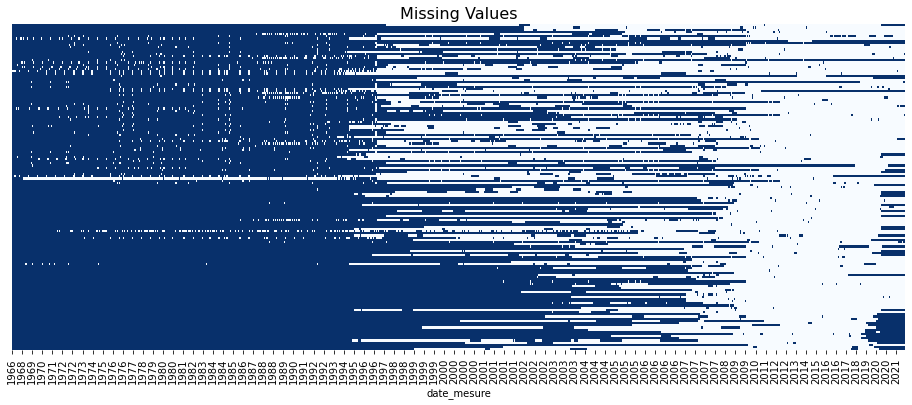

In [8]:
f_plot_nan(data)

# Traitement des données

## Rééchantillonnage à la semaine

In [9]:
data_week = pd.DataFrame(data.resample('7D').mean())

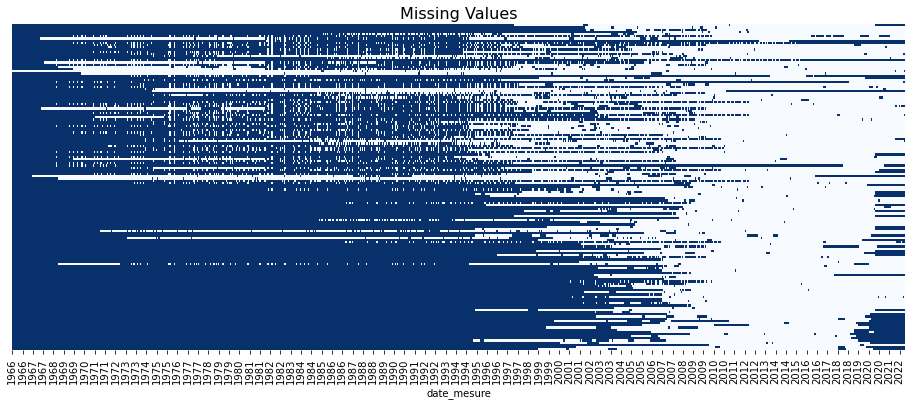

In [10]:
f_plot_nan(data_week)

In [11]:
data_week.shape

(2942, 149)

## Echelle de temps fixée après 2006 pour limiter les Nan

In [16]:
data_week_from_ = data_week.loc['01-01-2010':]

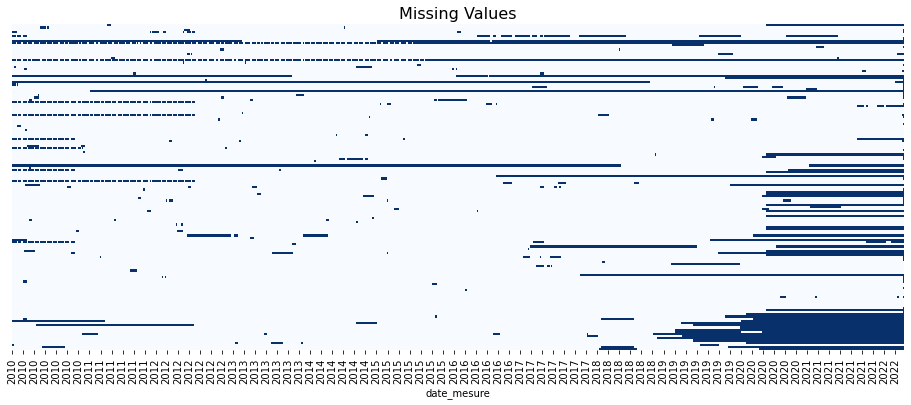

In [17]:
f_plot_nan(data_week_from_)

## Suppression des valeurs abbérantes
Utilisation de la méthode IQR pour supprimer les valeurs abbérantes.
- Calcul des quartiles et de l'écart interquartile
- Suppression des valeurs < Q1 - 1.5*IQR
- Suppression des valeurs > Q3 + 1.5*IQR

In [18]:
nbre_na = data_week_from_.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 10655 valeurs nulles dans l'ensemble du dataframe.


In [19]:
data_wo_outliers = data_week_from_.copy()

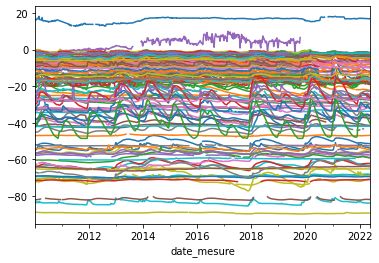

In [20]:
for piezo in data_wo_outliers.columns : 
    q1 = np.nanquantile(data_wo_outliers[f"{piezo}"], .25)
    q3 = np.nanquantile(data_wo_outliers[f"{piezo}"], .75)
    IQR = q3-q1
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] < (q1-1.5*IQR), piezo] = np.NaN
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] > (q3+1.5*IQR), piezo] = np.NaN
    data_wo_outliers[f"{piezo}"].plot()

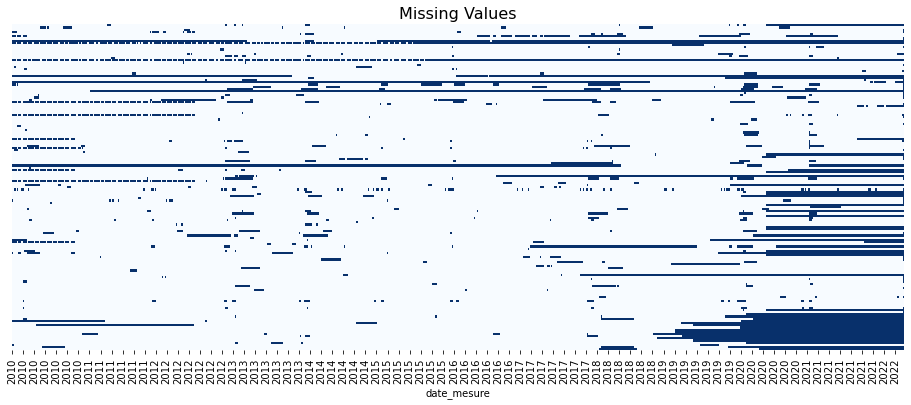

In [21]:
f_plot_nan(data_wo_outliers)

In [22]:
nbre_na_2 = data_wo_outliers.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_2} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 11999 valeurs nulles dans l'ensemble du dataframe.


## Suppression des piezos avec plus de 5% de valeurs manquantes

In [23]:
# Liste des piezos avec plus de 10% de valeurs manquantes
bss_to_drop = data.loc[:,data_wo_outliers.isna().sum()>0.05*data_wo_outliers.shape[0]].columns

In [24]:
data_clean = data_wo_outliers.copy().drop(bss_to_drop, axis=1)

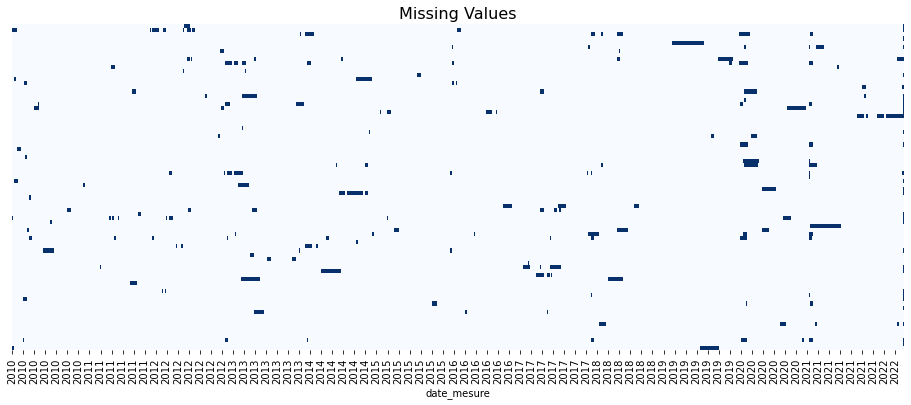

In [25]:
f_plot_nan(data_clean)

In [26]:
nbre_na_3 = data_clean.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_3} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 705 valeurs nulles dans l'ensemble du dataframe.


In [27]:
data_clean.shape

(647, 80)

## Interpolation

In [28]:
data_interpol = data_clean.copy().interpolate('linear')

In [29]:
data_interpol.shape

(647, 80)

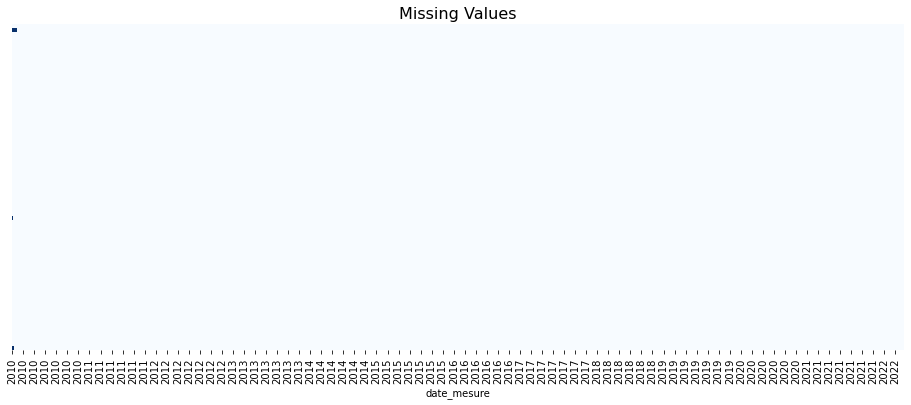

In [30]:
f_plot_nan(data_interpol)

## Réajustement des dates de début et de fin

In [31]:
debut = []
for column in data_interpol.columns:
    debut.append(data_interpol[f"{column}"].first_valid_index())
date_debut = max(debut)

In [32]:
fin = []
for column in data_interpol.columns:
    fin.append(data_interpol[f"{column}"].last_valid_index())
date_fin = min(fin)
date_fin

Timestamp('2022-05-23 00:00:00', freq='7D')

In [33]:
data_interpol = data_interpol.loc[date_debut:date_fin]

In [34]:
print(f"Nombre total de Nan : {data_interpol.isna().sum().sum()}")

Nombre total de Nan : 0


In [35]:
data_interpol.shape

(643, 80)

In [36]:
data_interpol.shape[1]

80

## Affichage des chroniques après nettoyage

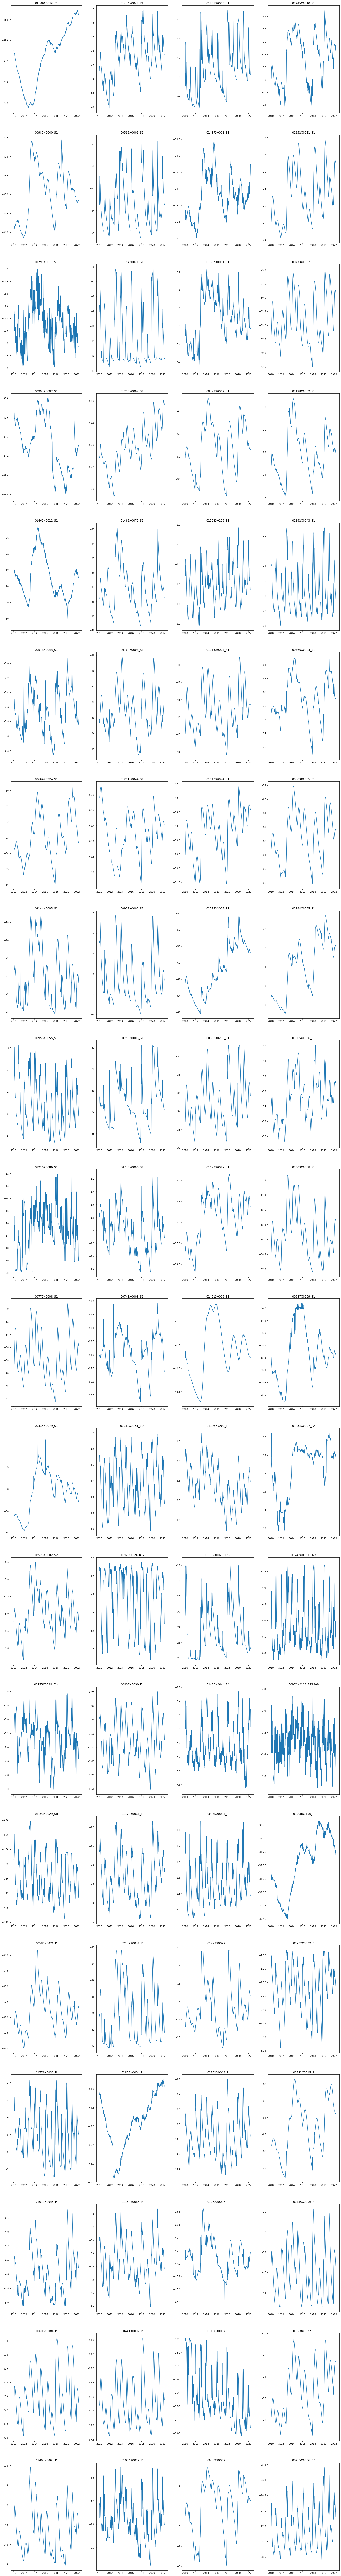

In [37]:
if data_interpol.shape[1]%4 == 0:
    nbre_lignes = data_interpol.shape[1]//4
else : 
    nbre_lignes = data_interpol.shape[1]//4 + 1

fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
#fig.suptitle('Series')
for i in range(nbre_lignes):
    for j in range(4):
        if i*4+j+1>data_interpol.shape[1]: # pass the others that we can't fill
            continue
        axs[i, j].plot(data_interpol.iloc[:,i*4+j])
        axs[i, j].set_title(data_interpol.columns[i*4+j])
plt.show()

## Normalisation StandardScaler

Comme il n'y a visuellement pas de valeurs abbérantes qui sautent aux yeux, la normalisation choisie est la standardisation

In [38]:
def scaleColumns(df):
    for col in df.columns:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col], index=df.index)
    return df

In [39]:
scaler = StandardScaler()
data_norm = scaleColumns(data_interpol.copy())

In [40]:
data_norm.head()

,01506X0016_P1,01474X0048_P1,01801X0010_S1,01245X0010_S1,00985X0040_S1,00592X0001_S1,01487X0001_S1,01252X0011_S1,01795X0011_S1,01184X0021_S1,...,01232X0006_P,00445X0006_P,00606X0086_P,00441X0007_P,01186X0007_P,00588X0037_P,01465X0067_P,01004X0019_P,00582X0069_P,00955X0066_PZ
date_mesure,,,,,,,,,,,,,,,,,,,,,
2010-02-01,0.245911,-0.408753,-0.127817,-1.044786,-1.348303,-0.000776,-0.804812,-1.185438,0.944852,1.225754,...,-0.048867,-0.091761,-0.817582,-0.093350,2.189809,-1.082879,-0.339442,0.735195,-0.366735,0.520036
2010-02-08,0.227490,-0.529731,-0.300129,-0.901012,-1.358460,0.761221,-0.782864,-1.139086,0.526408,1.071746,...,-0.126042,0.219342,-0.482325,-0.018685,2.189809,-1.044426,-0.197057,0.799956,-0.297370,0.362065
2010-02-15,0.227490,-0.646056,-0.629919,-0.814010,-1.356428,1.200271,-0.695074,-1.067452,0.037041,0.991005,...,-0.103992,0.379858,-0.284203,0.087236,2.207837,-1.059685,-0.031372,0.103775,-0.284158,0.613965
2010-02-22,0.202927,-0.310653,-0.666436,-0.758712,-1.352365,0.968068,-0.848707,-0.982239,0.865064,1.050813,...,0.033821,0.440850,-0.176406,0.196630,2.243893,-1.009025,0.240455,1.334235,-0.224702,0.716434
2010-03-01,0.131288,0.205054,1.195907,-0.442409,-1.362522,0.562381,-1.144998,-0.893281,0.650522,1.855740,...,0.463796,0.582690,0.064571,0.307759,2.288963,-0.891834,0.740098,1.439472,-0.065053,1.245852


## Sauvegarde du dataframe en csv

In [41]:
data_norm.to_csv(f"./data/piezo_clustering/{region}.csv", sep = ";")